In [1]:
import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat

import auxiliary_functions

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [2]:
net_rw = ContTempNetwork.load('/home/b/skoove/Desktop/entropy/paper_data/socio_pat_primary_school/primaryschoolnet',
                              attributes_list=['node_to_label_dict',
                      'events_table',
                      'times',
                      'time_grid',
                      'num_nodes',
                      '_overlapping_events_merged',
                      'start_date',
                      'node_label_array',
                      'male_array',
                      'female_array',
                      'node_first_start_array',
                      'node_last_end_array',
                      'node_class_array',
                      'datetimes'])

In [3]:
import pandas as pd
df = pd.read_csv('../paper_data/socio_pat_primary_school/primaryschool.csv',
                 header=None, sep='\t', names=['time','id1','id2','class1','class2'])

In [4]:
df['hour'] = df['time'] // 3600
df['minute'] = (df['time'] % 3600) / 60

In [5]:
net_times_hours = net_rw.times / 3600
flag10 = np.argmax(net_times_hours > 10)
flag12 = np.argmax(net_times_hours > 12)
flag14 = np.argmax(net_times_hours > 14)
flag16 = np.argmax(net_times_hours > 16)
flagday1 = np.argmax(net_times_hours > 18)
print(flag10, flag12, flag14, flag16, flagday1)

240 600 960 1320 1556


In [6]:
net_rw.times

Index([ 31220,  31240,  31260,  31280,  31300,  31320,  31340,  31360,  31380,
        31400,
       ...
       147960, 147980, 148000, 148020, 148040, 148060, 148080, 148100, 148120,
       148140],
      dtype='int64', name='times', length=3102)

In [7]:
print(net_times_hours[960])
print(net_rw.times[960])

14.005555555555556
50420


In [8]:
selected_lamdas = np.logspace(-5,0,10)

In [9]:
Conditional_S_selected_hr = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/conditional_S_selected_hr/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected_hr.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys))[0]][0])

In [10]:
S = Conditional_S_selected_hr[9]
dS_dt = auxiliary_functions.derivative(S[0:1556], net_rw.times[1:1557])
a = zip(net_times_hours[1:1557], dS_dt)
print([i for i in a])

[(8.677777777777777, 3.011895870559592e-05), (8.683333333333334, 0.0010139407372029025), (8.688888888888888, 0.0009663961115338318), (8.694444444444445, 0.0006998199011066242), (8.7, 0.002182199124548867), (8.705555555555556, 0.004201802418449883), (8.71111111111111, 0.004242371126469646), (8.716666666666667, 0.0030469672286598955), (8.722222222222221, 0.002004092397718013), (8.727777777777778, 0.0010248535901053097), (8.733333333333333, 0.0005800588208954738), (8.738888888888889, 0.0006322854505336428), (8.744444444444444, 0.0007326558889922729), (8.75, 0.0006403844508122314), (8.755555555555556, 0.0009592077619978462), (8.761111111111111, 0.0016249287494211034), (8.766666666666667, 0.001073950977978405), (8.772222222222222, 0.0011176114551977256), (8.777777777777779, 0.002295096646305958), (8.783333333333333, 0.0017577107637944233), (8.78888888888889, 0.0015819952380128593), (8.794444444444444, 0.0029301366465977778), (8.8, 0.0021699329354868736), (8.805555555555555, 0.00079479859273

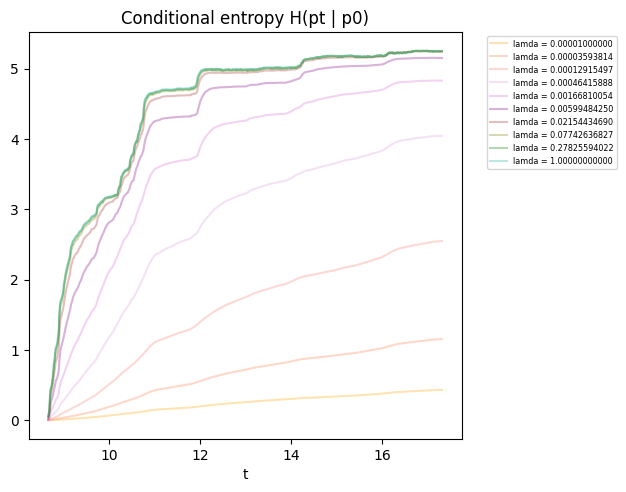

In [140]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = Conditional_S_selected_hr[i]
    plt.plot(net_times_hours[0:1556], S[0:1556], color = list_colors[i], alpha = 0.30, label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Conditional entropy H(pt | p0)')
#plt.savefig('/home/b/skoove/Desktop/primary_school/conditionalH_shaded.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## Change Point Detection

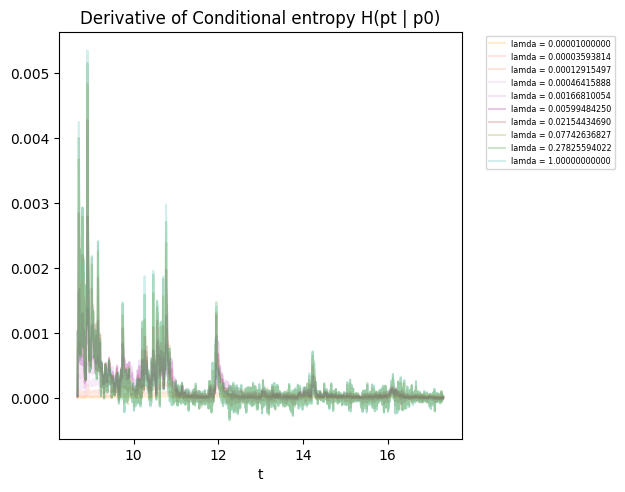

In [12]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = Conditional_S_selected_hr[i]
    dS_dt = auxiliary_functions.derivative(S[0:1556], net_rw.times[1:1557])
# Q2 = derivative(S2, between_lamdas_vNS)
    plt.plot(net_times_hours[1:1556], dS_dt, color = list_colors[i], alpha = 0.20, label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Derivative of Conditional entropy H(pt | p0)')
#plt.savefig('/home/b/skoove/Desktop/primary_school/derivative_conditionalH_shaded.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

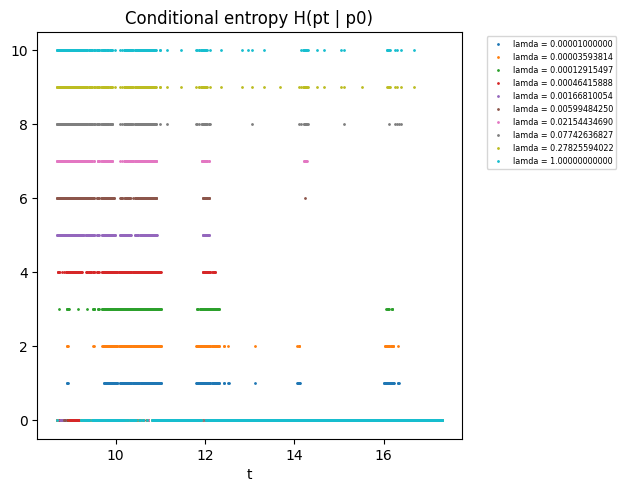

In [13]:
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = Conditional_S_selected_hr[i]
    dS_dt = auxiliary_functions.derivative(S[0:1556], net_rw.times[1:1557])
# Q2 = derivative(S2, between_lamdas_vNS)
    plt.scatter(net_times_hours[1:1556], (i+1)* auxiliary_functions.percentile_mask(dS_dt, 80), s=1, label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Conditional entropy H(pt | p0)')
#plt.savefig('/home/b/skoove/Desktop/primary_school/conditionalH.png', format='png', dpi=300)
plt.show()

### Transformations

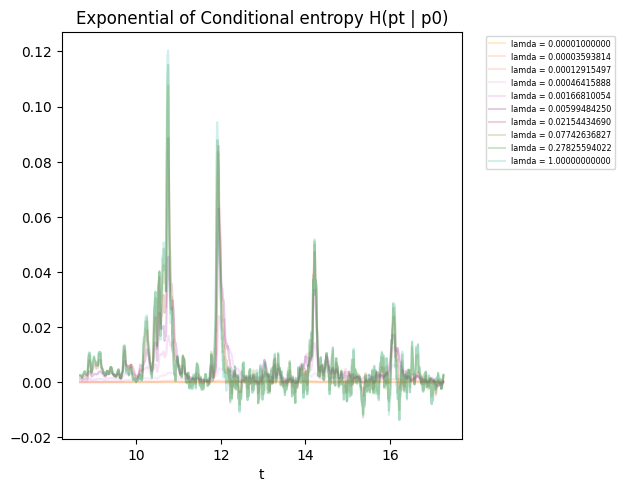

In [14]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = Conditional_S_selected_hr[i]
    dS_dt = auxiliary_functions.derivative(np.exp(S[0:1556]), net_rw.times[1:1557])
    dS_dt = auxiliary_functions.running_mean(dS_dt, 10)
# Q2 = derivative(S2, between_lamdas_vNS)
    plt.plot(net_times_hours[1:1547], dS_dt, color = list_colors[i], alpha = 0.20, label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Exponential of Conditional entropy H(pt | p0)')
#plt.savefig('/home/b/skoove/Desktop/primary_school/ma20_derivative_conditionalH.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

### Adjustment with complete graph

In [15]:
N = net_rw.num_nodes
H = lambda t: t*np.exp(-t) - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N-1))

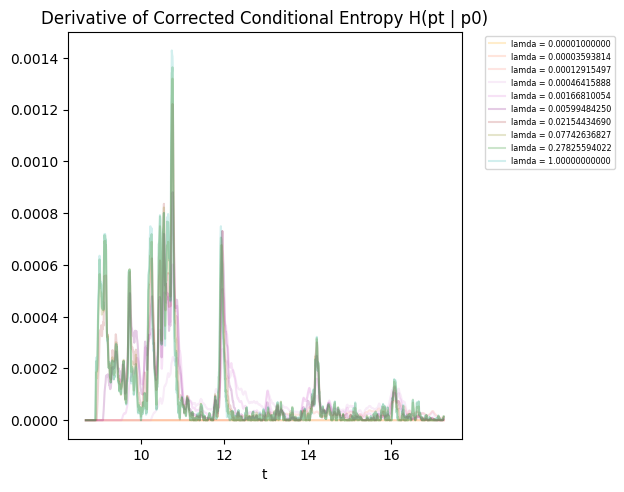

In [16]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = Conditional_S_selected_hr[i]
    dS_dt = auxiliary_functions.derivative([s - Hc(s) for s in S[0:1556]], net_rw.times[1:1557])
    dS_dt = auxiliary_functions.running_mean(dS_dt, 10)
# Q2 = derivative(S2, between_lamdas_vNS)
    plt.plot(net_times_hours[1:1547], np.maximum(0,dS_dt), color = list_colors[i], alpha = 0.20, label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Derivative of Corrected Conditional Entropy H(pt | p0)')
#plt.savefig('/home/b/skoove/Desktop/primary_school/ma10_derivative_corrected_conditionalH.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

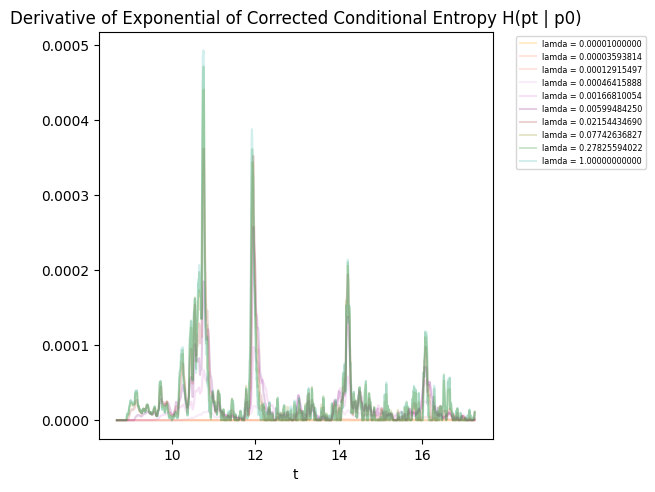

In [17]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = Conditional_S_selected_hr[i]
    dS_dt = auxiliary_functions.derivative([np.exp(s - H(s)) for s in S[0:1556]], net_rw.times[1:1557])
    dS_dt = auxiliary_functions.running_mean(dS_dt, 10)
# Q2 = derivative(S2, between_lamdas_vNS)
    plt.plot(net_times_hours[1:1547], np.maximum(0,dS_dt), color = list_colors[i], alpha = 0.20, label='lamda = ' + f'{lamda:.11f}')

plt.xlabel('t')
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Derivative of Exponential of Corrected Conditional Entropy H(pt | p0)')
#plt.savefig('/home/b/skoove/Desktop/primary_school/ma10_derivative_expcorrected_conditionalH.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## First Smoothing and then derivative

In [77]:
from scipy.signal import argrelextrema

def find_local_maxima(array, window_size):
    """
    Find the indices of local maxima in a NumPy array based on a given neighborhood size.
    
    Parameters:
        array (np.ndarray): Input array.
        window_size (int): Size of the neighborhood to consider for determining local maxima.
    
    Returns:
        np.ndarray: Indices of the local maxima.
    """
    # Define the order (half the window size)
    order = window_size // 2
    
    # Find indices of local maxima
    local_maxima_indices = argrelextrema(array, comparator=np.greater, order=order)[0]
    
    return local_maxima_indices

In [85]:
len(S)

3100

In [86]:
net_rw.times

Index([ 31220,  31240,  31260,  31280,  31300,  31320,  31340,  31360,  31380,
        31400,
       ...
       147960, 147980, 148000, 148020, 148040, 148060, 148080, 148100, 148120,
       148140],
      dtype='int64', name='times', length=3102)

In [110]:
[H(t) for t in net_rw.times[1:(1557)]-net_rw.times[0]]

[5.484796965469872,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,
 5.484796933490655,


In [116]:
smoothing_window = 10
S = Conditional_S_selected_hr[index]

print(len(dS_dt))
print(dS_dt)
dS_dt = auxiliary_functions.running_mean(dS_dt, smoothing_window)
print(len(dS_dt))

1555
[-1.4239125602697627e-06, -0.0020024994725440803, -0.0018663380282391278, -0.001906090298036646, -0.0014181943027068281, -0.0007573998803367787, -0.0007804809161681643, -0.0006057431077519188, -0.0006413803820240649, -0.0010741737399258071, -0.0012828633445916573, -0.0014500205996075765, -0.0015417429311151477, -0.0015246170192409702, -0.0013674852974448384, -0.0012552244834937525, -0.0014516284080824463, -0.0014030026153256075, -0.0009272075093157445, -0.001039384157179385, -0.0010097478907678703, -0.0005486796416360934, -0.0008480974461394841, -0.0013039052622490026, -0.0011830036774493208, -0.0010450413044374497, -0.000845388451628884, -0.0007677049512071598, -0.0006597509264931939, -0.0007047631280518163, -0.0011560457805036089, -0.0014221680861699725, -0.001253355669301351, -0.0011375533313927543, -0.0013311734223424771, -0.0010000731451760697, -0.0008231183513610546, -0.0007162986600605075, -0.0006052583076793683, -0.0006994994121657799, -0.0005639435426930157, -5.3623796564

In [96]:
len(net_times_hours)

3102

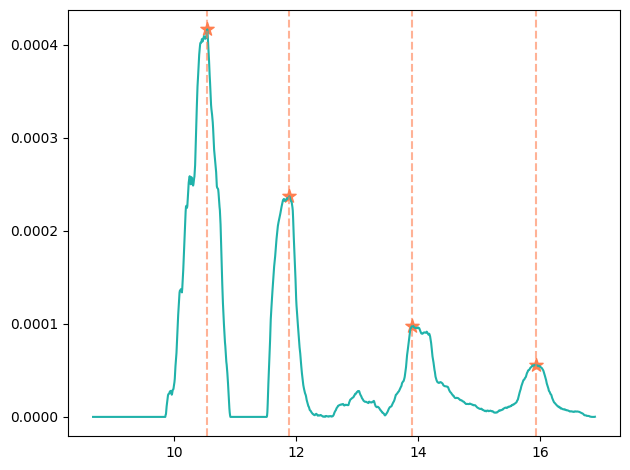

In [139]:
#Plot 5
color = 'lightseagreen'
index = 5

smoothing_window = 75
lamda = selected_lamdas[index]

S = Conditional_S_selected_hr[index]
dS_dt = auxiliary_functions.derivative([S[i] - H(t) for i,t in enumerate(net_times_hours[1:1557] - net_times_hours[0])],  net_rw.times[1:(1557)])
dS_dt = auxiliary_functions.running_mean(dS_dt, smoothing_window)
# Q2 = derivative(S2, between_lamdas_vNS)
plt.plot(net_times_hours[:1556- (smoothing_window)], np.maximum(0,dS_dt), color = color, alpha = 1)

local_window = 250
maxima = find_local_maxima(np.array(dS_dt), local_window)
maxima += 0

plt.scatter(net_times_hours[maxima], np.maximum(0,dS_dt)[maxima], color="coral", marker="*", s=100, label="Local maxima")  # Add stars at local maxima
for idx in maxima:
    plt.axvline(x=net_times_hours[idx], color="coral", linestyle="--", alpha=0.6)  # Add vertical lines

#plt.xlabel('t [h]')
#plt.ylabel("Entropy Rate")
#plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.title('Entropy Production Rate - Primary School Dataset')
plt.savefig('/home/b/skoove/Desktop/primary_school/netsci2025.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

### Dorian's Idea for change-point detection

In [ ]:
net_times_hours[1:1547]

/tmp/ipykernel_4032766/3823069674.py:10: RuntimeWarning: divide by zero encountered in divide
  signal_change = S / distance_from_asymptot


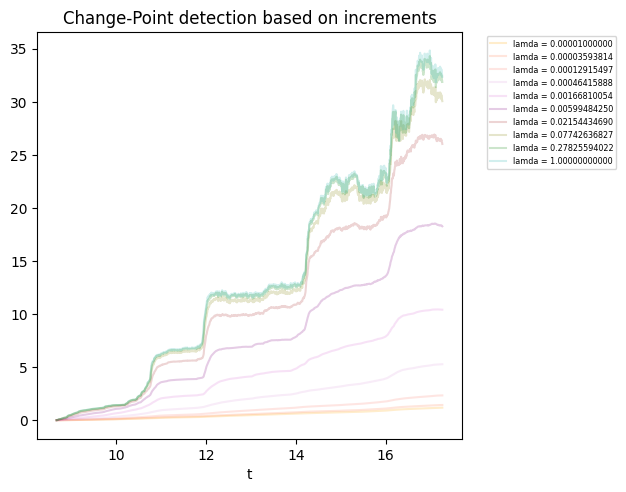

In [51]:
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = Conditional_S_selected_hr[i]
    increments = [S[0]]
    increments += list(np.diff(S))
    S = np.array(S)
    distance_from_asymptot = S[-1] - S
    increments = np.array(increments)
    signal_change = S / distance_from_asymptot
    
    plt.plot(net_times_hours[1:1547], signal_change[0:1546], color = list_colors[i], alpha = 0.20, label='lamda = ' + f'{lamda:.11f}')

plt.xlabel('t')
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Change-Point detection based on increments')
#plt.savefig('/home/b/skoove/Desktop/primary_school/ma10_derivative_expcorrected_conditionalH.png', format='png', dpi=300, bbox_inches='tight')
plt.show()
    

/tmp/ipykernel_4032766/780108692.py:11: RuntimeWarning: divide by zero encountered in divide
  signal_change = S / distance_from_asymptot


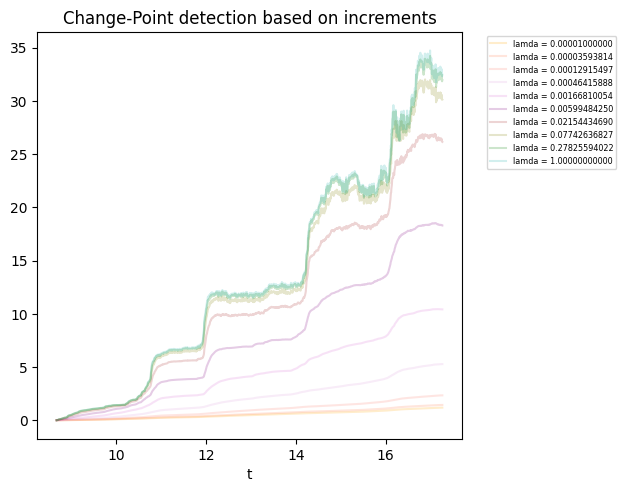

In [50]:
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = Conditional_S_selected_hr[i]
    increments = [S[0]]
    increments += list(np.diff(S))
    S = [0] + S[:-1]
    S = np.array(S)
    distance_from_asymptot = S[-1] - S
    increments = np.array(increments)
    signal_change = S / distance_from_asymptot
    
    plt.plot(net_times_hours[1:1547], signal_change[0:1546], color = list_colors[i], alpha = 0.20, label='lamda = ' + f'{lamda:.11f}')

plt.xlabel('t')
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Change-Point detection based on increments')
#plt.savefig('/home/b/skoove/Desktop/primary_school/ma10_derivative_expcorrected_conditionalH.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

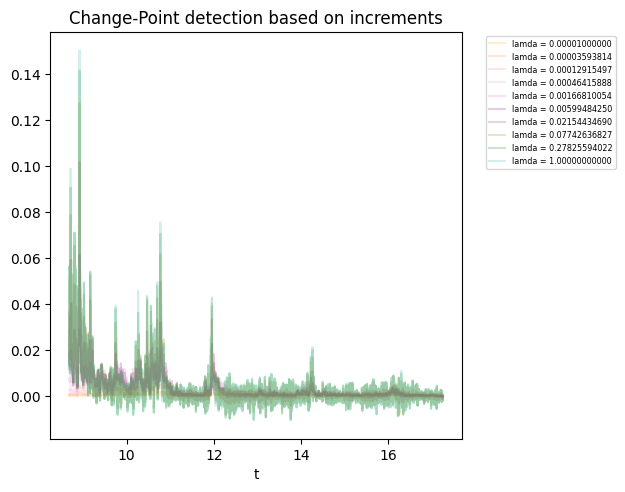

In [49]:
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = [0] + Conditional_S_selected_hr[i]
    increments = list(np.diff(S))
    S = np.array(S)
    distance_from_asymptot = S[-1] - S
    increments = np.array(increments)
    signal_change = increments / distance_from_asymptot[:-1]
    
    plt.plot(net_times_hours[1:1547], increments[0:1546], color = list_colors[i], alpha = 0.20, label='lamda = ' + f'{lamda:.11f}')

plt.xlabel('t')
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Change-Point detection based on increments')
#plt.savefig('/home/b/skoove/Desktop/primary_school/ma10_derivative_expcorrected_conditionalH.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## 

In [45]:
S = Conditional_S_selected_hr[9]
increments = [S[0]]
increments += list(np.diff(S))
S = np.array(S)
distance_from_asymptot = np.log(N) - S
increments = np.array(increments)
signal_change = increments / distance_from_asymptot
print(S)
print(signal_change)

[0.05656873 0.06826824 0.09712636 ... 5.40751163 5.40807772 5.40769705]
[ 0.01041327  0.00215832  0.00535221 ... -0.0192704   0.00700085
 -0.00468569]


In [48]:

print(S)
print(signal_change)

[0.         0.05656873 0.06826824 ... 5.40751163 5.40807772 5.40769705]
[1.04607799e-02 2.18636438e-03 5.40471915e-03 ... 1.13400340e+00
 3.05301263e+00 1.00000000e+00]


# Entropy Production Rate

In [17]:
S_rate_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/S_rate_selected_hr/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        S_rate_selected.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

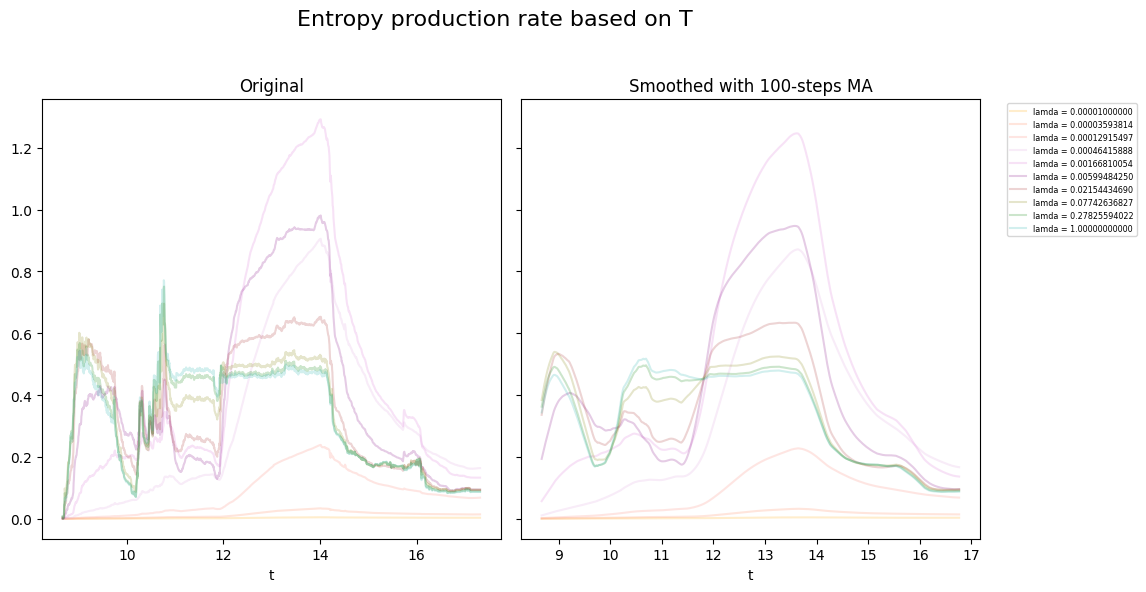

In [18]:
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 6))

for i, lamda in enumerate(selected_lamdas):
    S = S_rate_selected[i]
    n_smooth = 100
    smooth_S = auxiliary_functions.running_mean(S, n_smooth)
    
    axs[0].plot(net_times_hours[0:1556], S[0:1556], color=list_colors[i], alpha=0.2, label='lamda = ' + f'{lamda:.11f}')
    axs[0].set_xlabel('t')
    axs[1].plot(net_times_hours[0:1556-n_smooth+1], smooth_S[0:1556-n_smooth+1], color=list_colors[i], alpha=0.2, label='lamda = ' + f'{lamda:.11f}')
    axs[1].set_xlabel('t')

# Adding titles to each subplot
axs[0].set_title('Original')
axs[1].set_title(f'Smoothed with {n_smooth}-steps MA')

# Adding a global title to the figure
fig.suptitle('Entropy production rate based on T', fontsize=16)

# Adjusting the layout to make space for the global title
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle

# Adjust legend position
plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))

# Save the figure
#plt.savefig('/home/b/skoove/Desktop/primary_school/derivative_conditionalH.png', format='png', dpi=300)

# Show the plot
plt.show()


## Change Point Detection

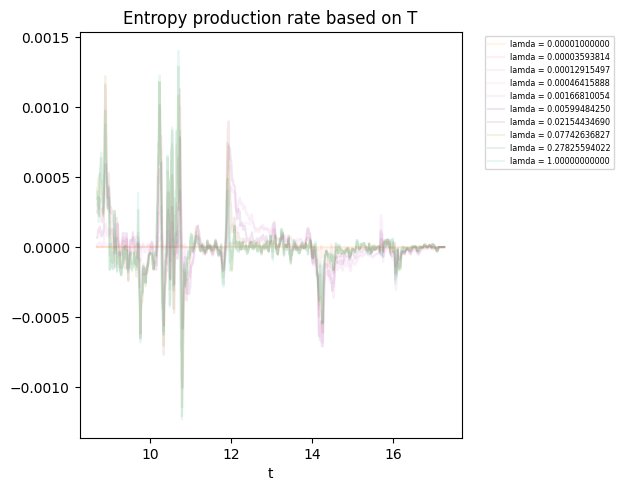

In [19]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = S_rate_selected[i]
    dS_dt = auxiliary_functions.derivative(S[0:1556], net_rw.times[1:1557])
    dS_dt = auxiliary_functions.running_mean(dS_dt, 10)
    plt.plot(net_times_hours[1:1547], dS_dt, color = list_colors[i], alpha = 0.1, label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Entropy production rate based on T')
#plt.savefig('/home/b/skoove/Desktop/primary_school/derivative_conditionalH.png', format='png', dpi=300)
plt.show()

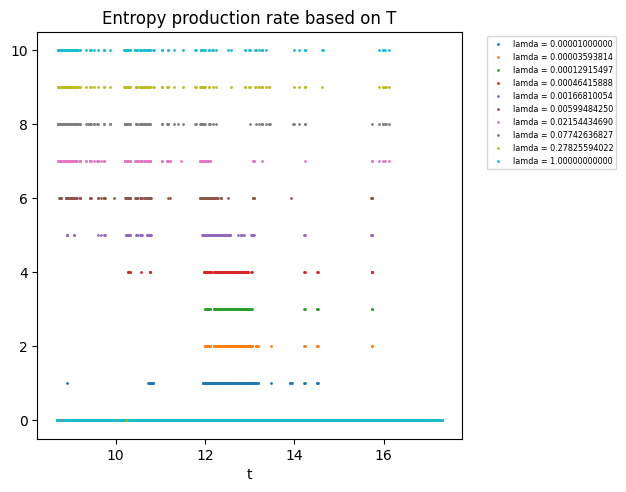

In [20]:
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = S_rate_selected[i]
    dS_dt = auxiliary_functions.derivative(S[0:1556], net_rw.times[1:1557])
# Q2 = derivative(S2, between_lamdas_vNS)
    plt.scatter(net_times_hours[1:1556], (i+1)*auxiliary_functions.percentile_mask(dS_dt, 90), s=1, alpha=1, label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Entropy production rate based on T')
#plt.savefig('/home/b/skoove/Desktop/primary_school/conditionalH.png', format='png', dpi=300)
plt.show()

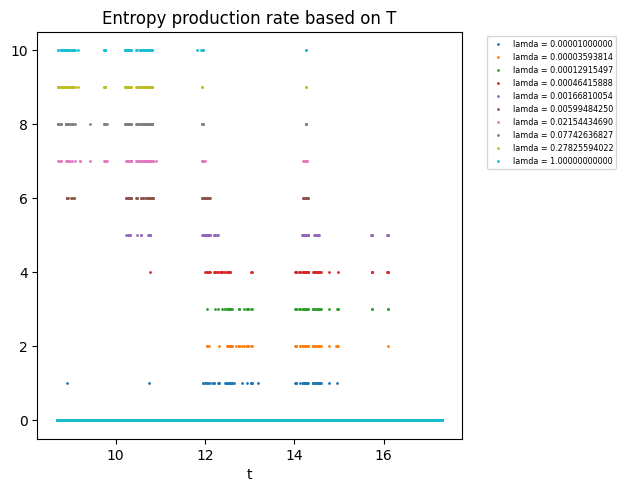

In [21]:
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    S = S_rate_selected[i]
    dS_dt = auxiliary_functions.derivative(S[0:1556], net_rw.times[1:1557])
# Q2 = derivative(S2, between_lamdas_vNS)
    plt.scatter(net_times_hours[1:1556], (i+1)*auxiliary_functions.percentile_mask(np.absolute(dS_dt), 95), s=1, alpha=1, label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Entropy production rate based on T')
#plt.savefig('/home/b/skoove/Desktop/primary_school/conditionalH.png', format='png', dpi=300)
plt.show()

In [22]:
vNS_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/vNSselected_hr/vNS{lamda:.11f}', 'rb') as f:
        vNS = pickle.load(f)
        vNS_selected.append(vNS['vNS'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

In [23]:
S = S_rate_selected[0]
dS_dt = auxiliary_functions.derivative(S[0:1556], net_rw.times[1:1557])
print(len(dS_dt))

1555
